In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import numpy as np
import os
import cv2, warnings
import matplotlib.pyplot as plt
import random
import nltk
nltk.download('wordnet')
seed = 111
np.random.seed(seed)
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
%config IPCompleter.use_jedi = False
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pickle
from torchtext.data.utils import get_tokenizer
import string
from collections import Counter
import time
from torch.utils.data import Dataset, DataLoader
from queue import PriorityQueue
import operator

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### Use GPU if available for all computations
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

#Show and Tell

##Feature Extractor

In [ ]:
def get_activation(name, _dict):
    """
    Input:
            - name: name of the layer whose activations you want to retrive
    Output:
            - hook: returns a forward hook to the specified layer
    """

    def hook(model, input, output):
        _dict[name] = output.detach()

    return hook


In [ ]:
### Helper Function - for applying transforms to image
def get_transforms():

    # Values for each channel (RGB) for normalizing
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

    # Convert image to tensor and normalize
    return transforms.Compose([transforms.ToTensor(), normalize])

In [ ]:
### A Function that extracts features from images
def extract_features(path, model, transforms):
    """
    Input:
            - path: path to directory where all the images are stored
            - model: pre-trained CNN model, that will be used as feature extractor
    Output:
            - dict: {image_name: feature_vector}
    """

    # Register a forward hook to the layer that outputs a feature vector - we are using Inception V3, and feature vector is returned by Mixed_7c layer
    activation = {}
    model.Mixed_7c.register_forward_hook(get_activation(name = "Mixed_7c", _dict = activation))

    # Pooling Function
    pool = nn.AdaptiveAvgPool2d((1, 1))

    # Dict to store features
    image_features = {}

    # Iterate through all images, extract features, store it in dict
    for file in tqdm(os.listdir(path)):

        img_name = file.split('.')[0]
        img_path = path + '/' + file

        # Load and re-size the image
        img = Image.open(img_path)
        img = img.resize((299, 299))

        # Pre-process the image, apply transforms
        img_tensor = transforms(img)
        img_tensor = torch.unsqueeze(img_tensor, dim = 0)

        # Forward prop image through model to extract features
        img_tensor = img_tensor.to(device)
        output = model(img_tensor)
        features = activation["Mixed_7c"]

        # Get 2048 dim feature vector by applying pooling
        features = pool(features)
        features = torch.squeeze(features).cpu().numpy()

        # Add image name and feature vector to dict
        image_features[img_name] = features

    return image_features

In [ ]:
### Creating an instance of pre-trained InceptionV3 - feature extractor
inception_v3 = models.inception_v3(weights="Inception_V3_Weights.DEFAULT")

### Set model to evaluation mode and load to device
inception_v3.eval()
inception_v3.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 254MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
### Specify path to directory where all the images are stored
images_path = "/content/Flicker8k_Dataset"

### Extract image features by calling 'extract_features' function
image_features = extract_features(path = images_path, model = inception_v3, transforms = get_transforms())

100%|██████████| 8091/8091 [04:47<00:00, 28.11it/s]


In [ ]:
### Dump extracted features into a pickle file for future use
pickle.dump(image_features, open('image_features.pkl', 'wb'))

##Word map+vocabulary

In [ ]:
### Helper function - for loading captions from txt file
def load_captions(path):
    """
    Input:
            - path: path to .txt file in which captions are stored
    Output:
            - list: a list of all captions
    """

    # A list & dict to store all captions for image
    captions_list = []
    image_captions = {}

    # Open the file containing captions
    with open(path, "r") as file:

        #Iterate through each line, append each caption to the list
        for line in file.readlines():

            # Extract caption by splitting the line into words
            words = line.strip("\n").split()

            # Join the words to form a caption, append to the list
            caption = ' '.join(words[1:])
            captions_list.append(caption)

    return captions_list

In [ ]:
### Helper Function - removing punctuation, tokenizing caption
def preprocess_caption(caption):
    """
    Input:
            - caption: raw caption to pre-process
    Output:
            - list: list of tokens; tokenized caption
    """

    # Tokenizer - it will automatically convert words to lower case and tokenize them
    tokenizer = get_tokenizer("basic_english")

    # Removing punctuations from caption
    caption = "".join([char for char in caption if char not in string.punctuation])

    # Tokenizing caption
    tokenized_caption = tokenizer(caption)

    return tokenized_caption

In [ ]:
### Helper Function - to build a vocabulary, we will apply all basic pre-processing here such as lower case, removing punctuation, tokenization, etc.
def build_vocabulary(captions_list, min_freq = 5):
    """
    Input:
            - list: a list containing all captions
            - min_freq: minimum count of a word to be part of the vocabulary
    Output:
            - dict: word mapping / vocabulary
    """

    # Frequency counter
    word_freq = Counter()

    # Pre-process the caption and update the frequency counter
    for caption in captions_list:

        # Preprocessing caption
        tokenized_caption = preprocess_caption(caption)

        # Update freq count
        word_freq.update(tokenized_caption)

    # Create word mapping / vocabulary
    words = [w for w in word_freq.keys() if word_freq[w] >= min_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    return word_map

In [ ]:
### Load Captions from given .txt file
tokens_path = "/content/Flickr8k.token.txt"
captions_list = load_captions(path = tokens_path)

### Build Vocabulary from captions
word_map = build_vocabulary(captions_list = captions_list, min_freq = 5)

In [ ]:
### Dump vocabulary into a pickle file for future use
pickle.dump(word_map, open('word_map_min5.pkl', 'wb'))

##Dataset

In [ ]:
### Helper Function - to create seperate file containing img - caption for given img list
def split_data(all_captions_path, img_list_path, name):
    """
    Input:
            - all_captions_path: path to .txt file containing all img - captions
            - img_list_path: path to .txt file containing images list
            - name: name to store the new .txt file containing image and caption Ex; train / dev / test
    """

    # Temp List to store all img names
    img_names = []

    # Extract Images Names from given file
    with open(img_list_path, "r") as file:

        # Iterate through each line, append each image to the list
        for line in file.readlines():

            # Get image name by reading lines, append it to the list
            img_name = line.strip("\n").split(".")[0]
            img_names.append(img_name)

    # Temp List to store lines for new file: img_name caption
    lines = []

    # Extract captions for images in temp img list
    with open(all_captions_path, "r") as file:

        # Iterate through each line and compare image name
        for line in file.readlines():

            # Get image name
            words = line.strip("\n").split()
            img_name = words[0].split(".")[0]

            if img_name in img_names:
                new_line = img_name + " " + " ".join(words[1:])
                lines.append(new_line)

    # Create new .txt file with given name
    with open(name + ".txt", "w") as file:

        # Write all lines to new txt file
        lines = map(lambda x:x + '\n', lines)
        file.writelines(lines)

In [ ]:
### Splitting the data as per the given files
all_captions_path = "/content/Flickr8k.token.txt"
train_list_path = "/content/Flickr_8k.trainImages.txt"
dev_list_path = "/content/Flickr_8k.devImages.txt"
test_list_path = "/content/Flickr_8k.testImages.txt"

# Creating train.txt
split_data(all_captions_path, train_list_path, "train")

# Creating dev.txt
split_data(all_captions_path, dev_list_path, "dev")

# Creating test.txt
split_data(all_captions_path, test_list_path, "test")

In [ ]:
### Helper Function - to convert raw captions to vectors; preprocess, apply word mapping, pad with zeros
def caption_to_vectors(caption, word_map, max_length):
    """
        Input:
                - caption: caption to process
                - word_map: vocabulary / dict containing mapping of all words to no
                - max_length: maximum length of sentence / caption
        Output:
                - _input: input vector
                - _output: output vector
    """

    # Pre-process caption
    caption = preprocess_caption(caption)

    # Append start token
    caption.insert(0, "<start>")

    # Create input and output words
    input_words = caption
    output_words = caption[1:]
    output_words.append("<end>")

    # Apply word mapping
    input_map = [word_map[k] if k in word_map.keys() else word_map["<unk>"] for k in input_words ]
    output_map = [word_map[k] if k in word_map.keys() else word_map["<unk>"] for k in output_words ]

    # Vectors of size max_len - used for 0 padding
    input_vector = np.zeros(max_length, dtype = np.int_)
    output_vector = np.zeros(max_length, dtype = np.int_)

    for i in range(len(input_map)):
        input_vector[i] = input_map[i]
        output_vector[i] = output_map[i]


    return input_vector, output_vector

In [ ]:
### Overriding Dataset Class
class NICDataset(Dataset):

    def __init__(self, data_path, image_features_path, word_map_path, max_length = 40):
        """
            Input:
                    - data_path: path to .txt file which contains img name caption
                    - image_features_path: path to the pkl file in which image_features dict is stored
                    - word_map_path: path to pkl file in which word mapping / vocabulary is stored
                    - max_length: maximum length of sentence
        """

        super().__init__()
        self.data_list = []
        self.image_features = pickle.load(open(image_features_path, "rb"))
        self.word_map = pickle.load(open(word_map_path, "rb"))
        self.max_length = max_length

        # Initialize data_list by reading .txt file from data path
        with open(data_path, "r") as file:
            #Iterate through each line to extract image names
            for line in file.readlines():

                # Append line to data list
                words = line.strip("\n")
                self.data_list.append(words)

    def __getitem__(self, index):

        # RetrivingShow and Tell: A Neural Image Caption Generator Line (img name caption) from data_list
        line = self.data_list[index]

        # Extracting img name & caption from line
        img_name = line.split()[0]
        caption = " ".join(line.split()[1:])

        # Creating Input and Target Variables
        """
            - input1: image feature vector of size 2048
            - input2: text; pre-processed caption corresponding to that image
            - target: output for each time stamp i.e. input shifted by left
        """

        input1 = self.image_features[img_name]
        input2, target = caption_to_vectors(caption, self.word_map, self.max_length)

        return input1, input2, target

    def __len__(self):
        return len(self.data_list)

In [ ]:
### Creating dataset objects
train_dataset = NICDataset(
        data_path = "train.txt",
        image_features_path = "/content/image_features.pkl",
        word_map_path = "/content/word_map_min5.pkl",
        max_length = 40
)

dev_dataset = NICDataset(
        data_path = "dev.txt",
        image_features_path = "/content/image_features.pkl",
        word_map_path = "/content/word_map_min5.pkl",
        max_length = 40
)

test_dataset = NICDataset(
        data_path = "test.txt",
        image_features_path = "/content/image_features.pkl",
        word_map_path = "/content/word_map_min5.pkl",
        max_length = 40
)

In [ ]:
print(len(train_dataset.data_list))
print(len(dev_dataset.data_list))
print(len(test_dataset.data_list))

30000
5000
5000


In [ ]:
### Creating Data loaders for model
train_data_loader = DataLoader(
        dataset = train_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)

dev_data_loader = DataLoader(
        dataset = dev_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)

test_data_loader = DataLoader(
        dataset = test_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers = 4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Model

In [ ]:
### Class NICModel
class NICModel(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Input:
                    - vocab_size: size of the vocabulary / word map, will be used for creating dense layers
                    - emb_dim: word embedding dimensions
                    - hidden_units: no. of hidden units in LSTM cell
        """

        # Initializing Model
        super(NICModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_units = hidden_units

        """
            dense1: it will be used to convert image features of size 2048 into emb_dim size
        """
        # Initializing Layers
        self.dropout = nn.Dropout(p = 0.5)
        self.softmax = nn.Softmax(dim = -1)
        self.batchnorm = nn.BatchNorm1d(num_features = self.emb_dim)
        self.embedding = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.emb_dim)
        self.dense1 = nn.Linear(in_features = 2048, out_features = self.emb_dim, bias = False)
        self.dense2 = nn.Linear(in_features = self.hidden_units, out_features = self.vocab_size)
        self.lstm = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units, batch_first = True)

    def forward(self, inputs, mode = "train"):
        """
            Input:
                    - list: [input1, input2] where input1 is 2048 dim img feature vector & input2 is input sentence
            Output:
                    - tensor: shape [batch_size * max_len, vocab_size]
        """

        # Extract inputs
        input1 = inputs[0]
        input2 = inputs[1]

        # Image Embedding
        x_img = self.dropout(input1)
        x_img = self.dense1(x_img)
        x_img = self.batchnorm(x_img)
        x_img = x_img.unsqueeze(dim = 1)

        # Text Embedding
        x_text = self.embedding(input2)
        x_text = self.dropout(x_text)

        # Encode Image using lstm
        _, h = self.lstm(x_img)


        # Initialize decoder with img encoding (h) and forward text
        A, _ = self.lstm(x_text, h)

        # Apply Dense to get op of shape vocab_size, reshaping from [batch_size, max_len, vocab_size] to [batch_size * max_len, vocab_size]
        outputs = self.dense2(A)
        outputs = outputs.view(-1, self.vocab_size)

        return outputs

##Training

In [ ]:
### Creating instance of NICModel
nic = NICModel(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
#nic.load_state_dict(torch.load("../input/flicker8k-image-captioning/nic_weights/nic_500_epochs_0.01_lr_no_l2.pth", map_location = device))

In [ ]:
### Loading model to available device GPU / CPU
nic.to(device)

### Defining Model Parameters
learning_rate = 0.01
optimizer = torch.optim.SGD(nic.parameters(), lr = learning_rate)
loss_criterion = nn.CrossEntropyLoss()
epochs = 200

### Logs
train_loss = []
dev_loss = []

In [ ]:
### Training Code
for epoch in range(epochs):

    nic.train()

    # Running Variables
    start_time = time.time()
    train_run_loss = []
    dev_run_loss = []
    index = 0

    # Iterate through training batches
    for input1, input2, target in train_data_loader:

        # Prepare input & target variables, load to device
        _input = [input1.to(device), input2.to(device)]
        target = target.view(-1)
        target = target.to(device)

        # Reset Gradients
        optimizer.zero_grad()

        # Get Predictions - Outputs
        output = nic(_input, mode = "train")

        # Calculate loss, gradients and step backward
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()

        # Append Loss and print iteration details
        train_run_loss.append(loss.item())
        """
        if (index+1) % 25 == 0:
            print("[Train {}] Iteration {} | Running Loss: {}".format(epoch+1, index+1, round(np.mean(train_run_loss), 4)))
        index += 1
        """

    # Final Epoch Loss
    avg_loss = np.mean(train_run_loss)
    train_loss.append(avg_loss)
    end_time = time.time()
    print("[Train] Epoch {} | Average Loss: {} | Time: {}".format(epoch+1, round(avg_loss, 4), round(end_time-start_time, 2)))

    # Perform validation after every 10 epochs
#    if (epoch+1) % 10 == 0:

    nic.eval()
    start_time = time.time()
    index = 0

    # Iterate through dev batches
    for input1, input2, target in dev_data_loader:

        with torch.no_grad():

            # Prepare input & target variables, load to device
            _input = [input1.to(device), input2.to(device)]
            target = target.view(-1)
            target = target.to(device)

            # Get Predictions - Outputs
            output = nic(_input, mode = "valid")

            # Calculate loss, gradients and step backward
            loss = loss_criterion(output, target)

            # Append Loss and print iteration details
            dev_run_loss.append(loss.item())
            """
            if (index+1) % 25 == 0:
                print("[Valid {}] Iteration {} | Running Loss: {}".format(epoch+1, index+1, round(np.mean(dev_run_loss), 4)))
            index += 1
            """

    # Final Epoch Loss
    avg_loss = np.mean(dev_run_loss)
    dev_loss.append(avg_loss)
    end_time = time.time()
    print("\n[Valid] Epoch {} | Average Loss: {} | Time: {}\n".format(epoch+1, round(avg_loss, 4), round(end_time-start_time, 2)))

    # Save model after every 100 epochs
    if (epoch+1) % 100 == 0:
        torch.save(nic.state_dict(), "nic_{}_epochs.pth".format(200+epoch+1))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Train] Epoch 1 | Average Loss: 1.0832 | Time: 11.3

[Valid] Epoch 1 | Average Loss: 1.0953 | Time: 1.06

[Train] Epoch 2 | Average Loss: 1.0825 | Time: 10.79

[Valid] Epoch 2 | Average Loss: 1.0965 | Time: 1.06

[Train] Epoch 3 | Average Loss: 1.0819 | Time: 10.72

[Valid] Epoch 3 | Average Loss: 1.092 | Time: 1.03

[Train] Epoch 4 | Average Loss: 1.0813 | Time: 10.29

[Valid] Epoch 4 | Average Loss: 1.0915 | Time: 1.56

[Train] Epoch 5 | Average Loss: 1.0809 | Time: 10.04

[Valid] Epoch 5 | Average Loss: 1.0914 | Time: 1.22

[Train] Epoch 6 | Average Loss: 1.0801 | Time: 13.53

[Valid] Epoch 6 | Average Loss: 1.0906 | Time: 1.65

[Train] Epoch 7 | Average Loss: 1.0797 | Time: 13.2

[Valid] Epoch 7 | Average Loss: 1.0916 | Time: 1.05

[Train] Epoch 8 | Average Loss: 1.0787 | Time: 11.78

[Valid] Epoch 8 | Average Loss: 1.089 | Time: 1.04

[Train] Epoch 9 | Average Loss: 1.0783 | Time: 10.67

[Valid] Epoch 9 | Average Loss: 1.0887 | Time: 1.07

[Train] Epoch 10 | Average Loss: 1.0775 |

In [ ]:
torch.save(nic.state_dict(), "/content/drive/MyDrive/3.urtea/KBI/PRAKTIKA KBI/Models/nic_200_epochs.pth")

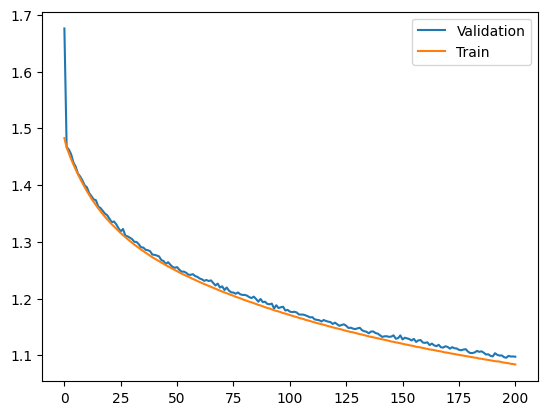

In [ ]:
plt.plot(range(201), dev_loss, label = "Validation")
plt.plot(range(201), train_loss, label = "Train")
plt.legend()
plt.show()

##Inferentzia

In [ ]:
### Encoder Model - for encoding image features
class NIC_Encoder(NICModel):

    # Here, we need to override only the forward method, to encode the image.

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Inputs:
                    same as NICModel
        """
        super(NIC_Encoder, self).__init__(vocab_size, emb_dim, hidden_units)

    # Overriding the forward method
    def forward(self, x_img):
        """
            Input:
                    - x_img: [batch_size, 2048] shape img feature vector
            Output:
                    - A, h: outputs of lstm
        """

        # Image Embedding
        x_img = self.dense1(x_img)
        x_img = self.batchnorm(x_img)
        x_img = x_img.unsqueeze(dim = 1)

        # Encode Image
        A, h = self.lstm(x_img)

        return A, h

In [ ]:
### Decoder Model - for decoding text
class NIC_Decoder(NICModel):

    def __init__(self, vocab_size, emb_dim, hidden_units):
        """
            Inputs:
                    same as NICModel
        """
        super(NIC_Decoder, self).__init__(vocab_size, emb_dim, hidden_units)

    def forward(self, x_text, h):
        """
            Input:
                    - x_text: [batch_size, 1] shape input word
                    -h: previous hidden states of lstm (img enc in case of 1st word)
            Output:
                    - A, h: outputs of lstm
        """

        # Text Embedding
        x_text = self.embedding(x_text)

        # Get predictions
        A, h = self.lstm(x_text, h)
        A = self.dense2(A)
        A = self.softmax(A)

        return A, h


In [ ]:
### Node - to store intermediate informations
class BeamSearchNode(object):

    def __init__(self, hidden_state, previous_node, word_id, log_prob, length):
        """
            Inputs:
                    - hidden_state: returned from lstm for previous input word, used to init lstm for predicting next word
                    - previous_node: used for backtracking
                    - word_id: index of the word in vocabulary
                    - log_prob: log of P(y_hat^<t> | y_hat^<0>...y_hat^<t-1>)
                    - length: length of beam so far, if it exceeds max_length, we need to stop
        """
        self.hidden_state = hidden_state
        self.previous_node = previous_node
        self.word_id = word_id
        self.log_prob = log_prob
        self.length = length

    def eval(self, alpha = 1.0):
        """
            Used to calculate normalized score (length independent)
        """
        reward = 0
        return self.log_prob / float(self.length - 1 + 1e-6) + alpha * reward

In [ ]:
### Function to execute beam search
def beam_search(cnn_model, nic_encoder, nic_decoder, img_path, id_to_word, transforms, max_length = 40, beam_width = 3, no_of_op = 1):
    """
        Inputs:
                cnn_model: CNN Model from which image features are to be extracted, here inception V3
                nic_encoder: Encoder model to retrive img encodings
                nic_decoder: Decoder model for text
                img_path: path where the image is stored ex: bla/bla/bla/img.jpg
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
                beam_width: top k to select
                no_of_op: number of output sentences / captions you want per image

        Outputs:
                caption: predicted caption for given image

        Warning:
                I've used batch size of 1 only, so call inference_greedy function for each image
    """

    # Register a forward hook to the layer that outputs a feature vector
    # We are using Inception V3, and feature vector is returned by Mixed_7c layer
    activation = {}
    cnn_model.Mixed_7c.register_forward_hook(get_activation(name = "Mixed_7c", _dict = activation))

    # Pooling Function
    pool = nn.AdaptiveAvgPool2d((1, 1))

    # Extract Image Features

    img = Image.open(img_path)
    img = img.resize((299, 299))

    # Pre-process the image, apply transforms
    img_tensor = transforms(img)
    img_tensor = torch.unsqueeze(img_tensor, dim = 0)

    # Forward prop image through model to extract features
    img_tensor = img_tensor.to(device)
    output = cnn_model(img_tensor)
    features = activation["Mixed_7c"]

    # Get 2048 dim feature vector by applying pooling
    features = pool(features)
    features = features.view(1, 2048)

    # Encode image
    _, h = nic_encoder(features)

    # Prepare 1st input word
    start = 2993 # index of '<start>' in vocabulary
    x_text = torch.tensor(start, device = device).view(1,1)

    # Priority Queue - to store nodes, a list to store end nodes
    nodes = PriorityQueue()
    endnodes = []

    # Starting Node for beam search
    node = BeamSearchNode(hidden_state = h, previous_node = None, word_id = x_text, log_prob = 0, length = 1)
    nodes.put((-node.eval(), node))
    queue_size = 1

    # Start Beam Search
    while True:

        # If queue size exceeds, then stop
        #if queue_size > 2000: break

        # Fetch node with best score from queue
        score, node = nodes.get()
        x_text = node.word_id
        h = node.hidden_state

        # Check for <end>
        if id_to_word[x_text.item()] == "<end>" and node.previous_node != None:

            # Append this endnode to the list
            endnodes.append((score, node))

            # Check for max no of outputs
            if len(endnodes) >= no_of_op:
                break
            else:
                continue

        # Decode for one step
        A, h = nic_decoder(x_text, h)

        # Get top K elements
        A_topK, indices_topK = torch.topk(A, beam_width)

        # Create Nodes for these topK elements, and push it on the queue
        for topK in range(beam_width):

            # Get word id and log_prob for node
            word_id = indices_topK[0][0][topK].view(1, 1)
            prob = A_topK[0][0][topK].item()
            log_prob = np.log(prob)

            # Create node and add to queue
            new_node = BeamSearchNode(hidden_state = h, previous_node = node, word_id = word_id,
                                      log_prob = node.log_prob + log_prob, length = node.length + 1)
            nodes.put((-new_node.eval(), new_node))

        queue_size += beam_width - 1

    # If it does not generate <end> in any step, then endnodes will be empty
    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(no_of_op)]

    # Process nodes, assemble caption
    top_n_captions = []
    for score, node in sorted(endnodes, key = operator.itemgetter(0)):

        # Append word from node to sentence
        caption = []
        caption.append(node.word_id.item())

        # Iterate till <start> (here we are backtracking, so caption is reverse)
        while node.previous_node != None:
            node = node.previous_node
            caption.append(node.word_id.item())

        # Reverse the caption
        caption = caption[::-1]

        # Convert word id to word, remove start & end tokens
        caption = [id_to_word[key] for key in caption if id_to_word[key] != "<start>" if id_to_word[key] != "<end>"]
        caption = " ".join(caption)

        top_n_captions.append(caption)

    return top_n_captions

In [ ]:
### Creating an instance of pre-trained InceptionV3 - feature extractor, nic_encoder and nic_decoder models
inception_v3 = models.inception_v3(pretrained = True)

nic_encoder = NIC_Encoder(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
nic_encoder.load_state_dict(torch.load("/content/drive/MyDrive/3.urtea/KBI/PRAKTIKA KBI/Models/nic_200_epochs.pth",
                                                map_location = device))

nic_decoder = NIC_Decoder(vocab_size = len(word_map), emb_dim = 512, hidden_units = 512)
nic_decoder.load_state_dict(torch.load("/content/drive/MyDrive/3.urtea/KBI/PRAKTIKA KBI/Models/nic_200_epochs.pth",
                                                map_location = device))

### Set model to evaluation mode and load to device
inception_v3.eval()
inception_v3.to(device)

nic_encoder.eval()
nic_encoder.to(device)

nic_decoder.eval()
nic_decoder.to(device)

### word_to_index: reverse mapping of vocab
id_to_word = {v:k for k,v in word_map.items()}

a black dog is running through the grass
a black dog is running through the water
a black dog is running through the snow


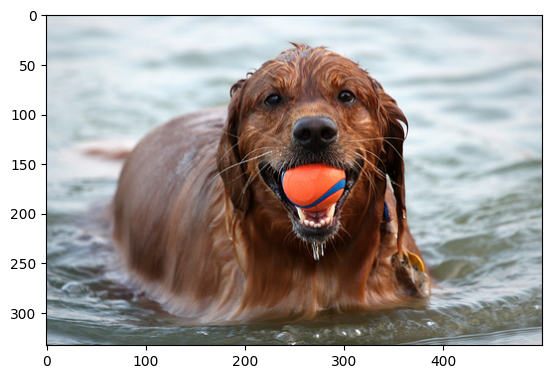

In [ ]:
### Sample Inference - Greedy
img_path = "/content/Flicker8k_Dataset/3048597471_5697538daf.jpg"
img = Image.open(img_path)
captions = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                           id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 10, no_of_op = 3)

plt.imshow(img)

for caption in captions:
    print(caption)

In [ ]:
### Function to evaluate performance by Blue Score
def evaluate_bleu(test_path, imgs_path, models, id_to_word, transforms, max_length, beam_width):
    """
        Inputs:
                test_path: path to test.txt file containing img ids and gt captions
                imgs_path: path to dir where all images are stored
                models: (cnn, encoder, decoder) tuple containing all 3 req models
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
                beam_width: top k to select
        Outputs:
                bleu score
    """

    #A dict containing img ids and list of gt captions : {'img_id' : []}
    img_caps = {}
    with open(test_path, "r") as file:

        #Iterate through each line to extract image names
        for line in file.readlines():

            #Get img id
            words = line.strip("\n")
            img_id = words.split()[0]
            caption = words.split()[1:]
            caption = preprocess_caption(" ".join(caption))

            #Append to dict
            if img_id in img_caps.keys():
                img_caps[img_id].append(caption)
            else:
                img_caps[img_id] = [caption]

    #Get Models
    cnn_model = models[0]
    nic_encoder = models[1]
    nic_decoder = models [2]

    #Lists to store bleu_score of each image
    b1_l = []; b2_l = []; b3_l = []; b4_l = []; met_l = [];

    #Find Bleu Score for each image
    for img, captions in tqdm(img_caps.items()):

        #For PriorityQueue Node error
        try:

            #Image path
            img_path = imgs_path + img + ".jpg"

            #Beam search to get top-1 caption
            caption = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                               id_to_word = id_to_word, transforms = transforms, max_length = max_length, beam_width = 10, no_of_op = 1)

            #Generate candidates and references for bleu_score function
            caption = preprocess_caption(caption)
            candidate = [caption]
            references = [captions]

            met = meteor_score(captions, caption)

            #Calculate Bleu Score
            b1 = bleu_score(candidate, references, weights=[1.0, 0, 0, 0])
            b2 = bleu_score(candidate, references, weights=[0.5, 0.5, 0, 0])
            b3 = bleu_score(candidate, references, weights=[0.33, 0.33, 0.33, 0])
            b4 = bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25])



            #Append to lists
            b1_l.append(b1); b2_l.append(b2); b3_l.append(b3); b4_l.append(b4); met_l.append(met)

        except:
            print("kaixo")
            continue

    #Calculate Avg
    b1_avg = np.mean(b1_l); b2_avg = np.mean(b2_l); b3_avg = np.mean(b3_l); b4_avg = np.mean(b4_l); met_avg = np.mean(met_l)

    return b1_avg, b2_avg, b3_avg, b4_avg, met_avg

In [ ]:


### Set paths
test_path = "test.txt"
imgs_path = "/content/Flicker8k_Dataset/"

### Evaluate
b1, b2, b3, b4, met = evaluate_bleu(test_path = test_path, imgs_path = imgs_path, models = (inception_v3, nic_encoder, nic_decoder),
             id_to_word = id_to_word, transforms = get_transforms(), max_length = 40, beam_width = 20)

print("B1 Score: ",b1)
print("B2 Score: ",b2)
print("B3 Score: ",b3)
print("B4 Score: ",b4)
print("Meteor Score: ",met)


100%|██████████| 1000/1000 [02:12<00:00,  7.57it/s]

B1 Score:  0.0777886606330738
B2 Score:  0.06305984354198513
B3 Score:  0.052536889825948556
B4 Score:  0.042007795617376976
Meteor Score:  0.29492408003521714


#ViT+GPT2

###DATUAK LORTU

In [ ]:
# Path to the images
IMAGES_PATH = "/content/Flicker8k_Dataset/"


IMAGE_SIZE = (299, 299) #Irudien dimentsioak
CAPTIONS_PER_IMG = 5 #Irudi bakoitzak zenbat cpaiton dituen

#Entrenamendu hiperparametroak
BATCH_SIZE = 16
EPOCHS = 30


In [ ]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            #img_name = os.path.join(IMAGES_PATH, img_name.strip())
            img_name = img_name.strip()


            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        return caption_mapping, text_data
# Dataset-a load
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

In [ ]:
captions_mapping


{'1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
  '<start> A girl going into a wooden building . <end>',
  '<start> A little girl climbing into a wooden playhouse . <end>',
  '<start> A little girl climbing the stairs to her playhouse . <end>',
  '<start> A little girl in a pink dress going into a wooden cabin . <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>',
  '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
  '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
  '<start> Two dogs of different breeds looking at each other on the road . <end>',
  '<start> Two dogs on pavement moving toward each other . <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
  '<start> A little gir

###DATASET SORRERA

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from torchvision.transforms import transforms
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((356, 356)),
            transforms.RandomCrop(IMAGE_SIZE), # Image augmentation
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
#Dataseta sortu
class customDataset(Dataset):
    def __init__(self, captions_f, imagesDir, transform=None, test = False):
        self.test = test
        self.root_dir = imagesDir
        self.captions = open(captions_f,'rb').read().decode('utf-8').split('\n')[1:] #Leheneoga kendu in ber da
        self.images_names = os.listdir(imagesDir)
        self.transform = transform
    def __len__(self):
        return len(self.captions)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.images_names[int(idx / CAPTIONS_PER_IMG)])
        img = cv2.imread(img_name, 1)

        if self.transform: #transforms ez bada irudi hutsa, kargatu

            img = self.transform(img)
        if not self.test:
          return img, captions_mapping[os.path.basename(img_name)][idx % CAPTIONS_PER_IMG]

        return img, os.path.basename(img_name)


train_data = customDataset("/content/Flickr_8k.trainImages.txt", "/content/Flicker8k_Dataset", transform = transform)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

dev_data = customDataset("/content/Flickr_8k.devImages.txt", "/content/Flicker8k_Dataset", transform = transform)
dev_dataloader = DataLoader(dev_data, batch_size=64, shuffle=True)

test_data = customDataset("/content/Flickr_8k.testImages.txt", "/content/Flicker8k_Dataset", transform = transform, test=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
#Irudikatu irudi bat eta bere kaptiona
def irudikatu(img, capt):
  plt.figure(figsize=(5,5))
  print(img.shape)
  plt.imshow(cv2.cvtColor(img.permute(1, 2, 0).numpy()))

  print(capt)

In [ ]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
num = random.randint(0, len(train_data))
irudikatu(*test_data[num])

NameError: ignored

###Ereduak


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
#https://huggingface.co/nlpconnect/vit-gpt2-image-captioning eredu hau TESTeko asuntuek ondo probatzeko erabiliet
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [ ]:
from torch.optim import Adam
epoch = 15
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
optimizer = Adam(model.parameters(), lr = 0.0001)
topil = transforms.ToPILImage()
losses = []
lossVal = []
for e in range(epoch):
  for idx, data in enumerate(train_dataloader):
    model.train(True)

    image, target = data
    optimizer.zero_grad()
    pixel_values = feature_extractor([topil(i) for i in image], return_tensors="pt").pixel_values.to(device)
    labels = tokenizer(
        target,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).input_ids.to(device)
    loss = model(pixel_values=pixel_values, labels=labels).loss
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()
    del image
    del target
    del pixel_values

  losses.append(loss)
  print(f"{e} epoch-ean entrenamendu loss {loss}")

  for idx, data in enumerate(dev_dataloader):
    with torch.no_grad:
      image, target = data
      pixel_values = feature_extractor([topil(i) for i in image], return_tensors="pt").pixel_values.to(device)
      labels = tokenizer(
          target,
          return_tensors="pt",
          truncation=True,
          padding=True
      ).input_ids.to(device)
      # the forward function automatically creates the correct decoder_input_ids
      loss = model(pixel_values=pixel_values, labels=labels).loss
      del image
      del target
      del pixel_values
      torch.cuda.empty_cache()
  print(f"{e} epoch-ean validation loss {loss}")
  lossVal.append(loss)


torch.save(model.state_dict(), "/content/drive/MyDrive/modelo15.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 epoch-ean entrenamendu loss 1.168461799621582
0 epoch-ean validation loss 1.1073989868164062
1 epoch-ean entrenamendu loss 1.023917555809021


OutOfMemoryError: ignored

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/modelo15.pth"))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

In [ ]:
max_length = 25
num_beams = 1
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
topil = transforms.ToPILImage()
def predict_step(data, show = False):
  preds_batch = []
  for images in data:

    pixel_values = feature_extractor(images=topil(images), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    output_ids = model.generate(pixel_values, **gen_kwargs)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    preds_batch.append(preds)
    if show:
      plt.imshow(cv2.cvtColor(images.permute(1, 2, 0).numpy()))
  return preds_batch


In [ ]:
#Test balioa lortu
def test(reference_data, candidate_data):
  reference_data = [i[8:-8].split(" ") for i in reference_data] #<Start> eta <Stop> seinuak kendu. Baita puntuak
  candidate_data  = " ".join(candidate_data).split(" ")
  for reference, candidate in zip(reference_data, [candidate_data] * CAPTIONS_PER_IMG): #[Candidate_data] * 5 egin dut 5 lista berak sortu eta ondoren zip erabili ahal izateko
    #BLEU
    bleu_1 = sentence_bleu(reference, candidate, weights = (1, 0, 0, 0))
    bleu_2 = sentence_bleu(reference, candidate, weights =  (0.5, 0.5, 0, 0))
    bleu_3 = sentence_bleu(reference, candidate, weights = (1/3,1/3, 1/3,0))
    bleu_4 = sentence_bleu(reference, candidate, weights =  (1/4, 1/4, 1/4, 1/4))

    #Meteor
  meteor = meteor_score(reference_data, candidate_data)
  return (bleu_1, bleu_2, bleu_3, bleu_4), meteor


In [ ]:
from torchtext.data.metrics import bleu_score

def test(reference_data, candidate_data):
  reference_data = [i[8:-8].split(" ") for i in reference_data] #<Start> eta <Stop> seinuak kendu. Baita puntuak
  candidate_data  = " ".join(candidate_data).split(" ")
    #BLEU
  bleu_1 = bleu_score([candidate_data], [reference_data],weights = (1, 0, 0, 0))
  bleu_2 = bleu_score( [candidate_data],[reference_data], weights =  (0.5, 0.5, 0, 0))
  bleu_3 = bleu_score( [candidate_data],[reference_data], weights = (1/3,1/3, 1/3,0))
  bleu_4 = bleu_score( [candidate_data],[reference_data], weights =  (1/4, 1/4, 1/4, 1/4))
    #Meteor
  meteor = meteor_score(reference_data, candidate_data)
  return (bleu_1, bleu_2, bleu_3, bleu_4), meteor

In [ ]:
with torch.no_grad():
    meteorTot = 0
    i = 0
    bleus = [0, 0, 0, 0]
    for data, target in test_dataloader:
        images = data.to('cuda')
        outputs = predict_step(images)
        for i, j in zip(outputs, target):
          bleu, meteor = test(captions_mapping[j], i)
          bleus[0] += bleu[0] / len(test_data)
          bleus[1] += bleu[1] / len(test_data)
          bleus[2] += bleu[2] / len(test_data)
          bleus[3] += bleu[3] / len(test_data)
          meteorTot += meteor / len(test_data)

0.75 0.7385489344596863 0.7254689931869507 0.7102991938591003
0.7210206526418734 0.6836547624882304 0.664780963505938 0.6496072350267085
0.75 0.7385489344596863 0.7254689931869507 0.7102991938591003
0.6811183350408715 0.6739359020714997 0.6659149691652404 0.6568677160564673
0.75 0.7385489344596863 0.7254689931869507 0.7102991938591003
0.6666666865348816 0.64549720287323 0.6197981238365173 0.5873949527740479
0.8999999761581421 0.8973645567893982 0.8945303559303284 0.8914703726768494
0.6900333109719925 0.6794978220800725 0.6674636951684125 0.6535068060257762
0.800000011920929 0.7928249835968018 0.7848808765411377 0.7760114669799805
0.699999988079071 0.6831300854682922 0.6631761789321899 0.6389431357383728
0.8181818127632141 0.809039831161499 0.7984820008277893 0.7860752940177917
0.6640732679962068 0.6515028788960388 0.6369226817770152 0.6196760384852286
0.800000011920929 0.7928249835968018 0.7848808765411377 0.7760114669799805
0.6348612936679605 0.6251681759575602 0.6140962447075471 0.60

In [ ]:
bleus, meteorTot

([0.7372547941402775,
  0.7195386477515696,
  0.6997367386663532,
  0.6767685648670806],
 0.8595439575551013)

### BLIP: Bootstrapping Language-Image Pre-training

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of two children walking down a path
two people walking down a path
<start> Two boys dressed in white capes running on a path in a field . <end>


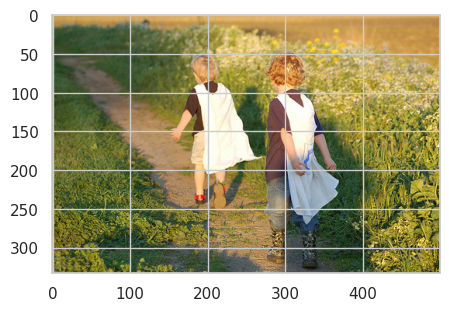

In [ ]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

num = random.randint(0, len(train_data))
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# conditional image captioning
text = "a photography of"
inputs = processor(train_data.__getitem__(num)[0], text, return_tensors="pt")  # irudi batekin bakarrik ainauk e

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(train_data.__getitem__(num)[0], return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
irudikatu(*train_data[num])

In [ ]:
### Function to evaluate performance by Blue Score
def evaluate_bleu(test_path, imgs_path, models, id_to_word, transforms, max_length, beam_width):
    """
        Inputs:
                test_path: path to test.txt file containing img ids and gt captions
                imgs_path: path to dir where all images are stored
                models: (cnn, encoder, decoder) tuple containing all 3 req models
                id_to_word: reverse mapping of word vocabulary / word map
                transforms: transforms to apply on img
                max_length: maximum length allowrd for caption
                beam_width: top k to select
        Outputs:
                bleu score
    """

    #A dict containing img ids and list of gt captions : {'img_id' : []}
    img_caps = {}
    with open(test_path, "r") as file:

        #Iterate through each line to extract image names
        for line in file.readlines():

            #Get img id
            words = line.strip("\n")
            img_id = words.split()[0]
            caption = words.split()[1:]
            caption = preprocess_caption(" ".join(caption))

            #Append to dict
            if img_id in img_caps.keys():
                img_caps[img_id].append(caption)
            else:
                img_caps[img_id] = [caption]

    #Get Models
    cnn_model = models[0]
    nic_encoder = models[1]
    nic_decoder = models [2]

    #Lists to store bleu_score of each image
    b1_l = []; b2_l = []; b3_l = []; b4_l = []; met_l = [];

    #Find Bleu Score for each image
    for img, captions in tqdm(img_caps.items()):

        #For PriorityQueue Node error
        try:

            #Image path
            img_path = imgs_path + img + ".jpg"

            #Beam search to get top-1 caption
            caption = beam_search(cnn_model = inception_v3, nic_encoder = nic_encoder, nic_decoder = nic_decoder,img_path = img_path,
                               id_to_word = id_to_word, transforms = transforms, max_length = max_length, beam_width = 10, no_of_op = 1)

            #Generate candidates and references for bleu_score function
            caption = preprocess_caption(caption)
            candidate = [caption]
            references = [captions]

            met = meteor_score(captions, caption)

            #Calculate Bleu Score
            b1 = bleu_score(candidate, references, weights=[1.0, 0, 0, 0])
            b2 = bleu_score(candidate, references, weights=[0.5, 0.5, 0, 0])
            b3 = bleu_score(candidate, references, weights=[0.33, 0.33, 0.33, 0])
            b4 = bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25])



            #Append to lists
            b1_l.append(b1); b2_l.append(b2); b3_l.append(b3); b4_l.append(b4); met_l.append(met)

        except:
            print("kaixo")
            continue

    #Calculate Avg
    b1_avg = np.mean(b1_l); b2_avg = np.mean(b2_l); b3_avg = np.mean(b3_l); b4_avg = np.mean(b4_l); met_avg = np.mean(met_l)

    return b1_avg, b2_avg, b3_avg, b4_avg, met_avg